# **CellTracksColab - TrackMate**
---

<font size = 4>Colab Notebook for Analyzing Migration Tracks generated by [TrackMate](https://imagej.net/plugins/trackmate/)


<font size = 4>Notebook created by [Guillaume Jacquemet](https://cellmig.org/)


# **0. Before getting started**
---

---
<font size = 4>**Important note**

<font size = 4>To load your TrackMate outputs, your dataset should be meticulously organized into a two-tiered folder hierarchy as depicted below. We also expect that your track files ends by _tracks and that your spot tables ends by _spots.

<font size = 4>Here's a common data structure that can work:

## Folder Hierarchy

- 📁 **Experiments** `[Folder_path]`
  - 🌿 **Condition_1** `[‘condition’ is derived from this folder name]`
    - 🔄 **R1** `[‘repeat’ is derived from this folder name]`
      - 📄 `FOV1_spots.csv`
      - 📄 `FOV1_tracks.csv`
      - 📄 `FOV2_spots.csv`
      - 📄 `FOV2_tracks.csv`
    - 🔄 **R2**
      - 📄 `FOV1_spots.csv`
      - 📄 `FOV1_tracks.csv`
      - 📄 `FOV2_spots.csv`
      - 📄 `FOV2_tracks.csv`
  - 🌿 **Condition_2**
    - 🔄 **R1**
    - 🔄 **R2**

<font size = 4>In this representation, different symbols are used to represent folders and files clearly:

📁 represents the main folder or directory.
🌿 represents the condition folders.
🔄 represents the repeat folders.
📄 represents the individual CSV files.

---
<font size = 4>**Important note 2**

<font size = 4>Be advised of one significant limitation inherent to this notebook.

<font size = 4 color="red">**Part2 does not support Track splitting**</font>. <font size = 4>For users aiming to compute additional track metrics within this environment, it is crucial to disable track splitting in TrackMate.

<font size = 4>It’s important to clarify that the absence of track splitting support does not hinder the notebook's ability to compile and display results in part 3 of the analysis process.







In [ ]:
# @title #MIT License

print("""
**MIT License**

Copyright (c) 2023 Guillaume Jacquemet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.""")

--------------------------------------------------------
# **Part 1: Prepare the session and load your data**
--------------------------------------------------------


## **1.1. Install key dependencies**
---
<font size = 4>

In [ ]:
#@markdown ##Play to install
!pip -q install pandas scikit-learn
!pip -q install hdbscan
!pip -q install umap-learn
!pip -q install plotly

import ipywidgets as widgets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import itertools
from matplotlib.gridspec import GridSpec

# Function to calculate Cohen's d
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    d = diff / np.sqrt(pooled_var)
    return d

import requests


# URL to the raw content of the version file in the repository
version_url = "https://raw.githubusercontent.com/guijacquemet/CellTracksColab/main/Notebook/latest_version.txt"

# Current version of the notebook the user is running
current_version = "0.4"

try:
    response = requests.get(version_url)
    response.raise_for_status()  # Check whether the request was successful
    latest_version = response.text.strip()  # Get the latest version from the version file

    if latest_version != current_version:
        print(f"A newer version of this notebook is available: {latest_version}. "
              f"Please download the latest version from the repository.")
    else:
        print("You are running the latest version of this notebook.")
except requests.RequestException as e:
    print("Could not check for the latest version of the notebook.")


## **1.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the instructions.

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive



## **1.3. Compile your data or load existing dataframes**
---

<font size = 4> Please ensure that your data is properly organised (see above)


In [ ]:
#@markdown ##Provide the path to your dataset:

#@markdown ###You have multiple TrackMate files you want to compile, provide the path to your:

Folder_path = ''  # @param {type: "string"}

#@markdown ###You have existing dataframes, provide the path to your:

Track_table = ''  # @param {type: "string"}
Spot_table = ''  # @param {type: "string"}


#@markdown ###Or use a test dataset
Use_test_dataset = True #@param {type:"boolean"}


#@markdown ###Provide the path to your Result folder

Results_Folder = "/content"  # @param {type: "string"}

import os
import re
import glob
import pandas as pd

def populate_columns(df, filepath):
    # Extract the parts of the file path
    path_parts = os.path.normpath(filepath).split(os.sep)

    if len(path_parts) < 3:
        # if there are not enough parts in the path to extract folder and parent folder
        print(f"Error: Cannot extract parent folder and folder from the filepath: {filepath}")
        return df

    # Assuming that the file is located at least two levels deep in the directory structure
    folder_name = path_parts[-2]  # The folder name is the second last part of the path
    parent_folder_name = path_parts[-3]  # The parent folder name is the third last part of the path

    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    df['File_name'] = remove_suffix(filename_without_extension)
    df['Condition'] = parent_folder_name  # Populate 'Condition' with the parent folder name
    df['experiment_nb'] = folder_name  # Populate 'Repeat' with the folder name

    return df

def load_and_populate(file_pattern, usecols=None):
    df_list = []
    pattern = re.compile(file_pattern)  # Compile the file pattern to a regex object

    # Go through each root, dirs, files triplet returned by os.walk
    for dirpath, dirnames, filenames in os.walk(Folder_path):
        for filename in filenames:
            if pattern.match(filename):  # Check if the filename matches the file pattern
                filepath = os.path.join(dirpath, filename)
                df = pd.read_csv(filepath, skiprows=[1, 2, 3], usecols=usecols)
                df_list.append(populate_columns(df, filepath))

    if not df_list:  # if df_list is empty, return an empty DataFrame
        print(f"No files found with pattern: {file_pattern}")
        return pd.DataFrame()

    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

def sort_and_generate_repeat(merged_df):
    merged_df.sort_values(['Condition', 'experiment_nb'], inplace=True)
    merged_df = merged_df.groupby('Condition', group_keys=False).apply(generate_repeat)
    return merged_df

def generate_repeat(group):
    unique_experiment_nbs = sorted(group['experiment_nb'].unique())
    experiment_nb_to_repeat = {experiment_nb: i+1 for i, experiment_nb in enumerate(unique_experiment_nbs)}
    group['Repeat'] = group['experiment_nb'].map(experiment_nb_to_repeat)
    return group

def remove_suffix(filename):
    suffixes_to_remove = ["_tracks", "_spots"]
    for suffix in suffixes_to_remove:
        if filename.endswith(suffix):
            filename = filename[:-len(suffix)]
            break
    return filename

if (Use_test_dataset):
  print("Downloading test dataset")
  !wget -nc -O /content/T_cell_dataset.zip https://github.com/guijacquemet/CellTracksColab/raw/main/Test_dataset/T_cell_dataset.zip && unzip -q /content/T_cell_dataset.zip -d /content
  Folder_path = "/content/Tracks"


def validate_tracks_df(df):
    """Validate the tracks dataframe for necessary columns and data types."""
    required_columns = ['TRACK_ID']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' missing in tracks dataframe.")
            return False

    # Additional data type checks or value ranges can be added here
    return True


def validate_spots_df(df):
    """Validate the spots dataframe for necessary columns and data types."""
    required_columns = ['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'POSITION_Z', 'POSITION_T']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' missing in spots dataframe.")
            return False

    # Additional data type checks or value ranges can be added here
    return True

# Existing code with added validation
if Folder_path:
    print("Merging CSV files....")
    merged_tracks_df = load_and_populate(r'.*tracks.*\.csv')

    if not validate_tracks_df(merged_tracks_df):
        print("Error: Validation failed for merged tracks dataframe.")
    else:
        merged_tracks_df = sort_and_generate_repeat(merged_tracks_df)
        merged_tracks_df['Unique_ID'] = merged_tracks_df['File_name'] + "_" + merged_tracks_df['TRACK_ID'].astype(str)
        merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)

    merged_spots_df = load_and_populate(r'.*spots.*\.csv')

    if not validate_spots_df(merged_spots_df):
        print("Error: Validation failed for merged spots dataframe.")
    else:
        merged_spots_df = sort_and_generate_repeat(merged_spots_df)
        merged_spots_df['Unique_ID'] = merged_spots_df['File_name'] + "_" + merged_spots_df['TRACK_ID'].astype(str)
        merged_spots_df.to_csv(Results_Folder + '/' + 'merged_Spots.csv', index=False)

# For existing dataframes
if Track_table:
    print("Loading track table file....")
    merged_tracks_df = pd.read_csv(Track_table)
    if not validate_tracks_df(merged_tracks_df):
        print("Error: Validation failed for loaded tracks dataframe.")

if Spot_table:
    print("Loading spot table file....")
    merged_spots_df = pd.read_csv(Spot_table)
    if not validate_spots_df(merged_spots_df):
        print("Error: Validation failed for loaded spots dataframe.")


## **1.4. Visualise your tracks**
---

In [ ]:
# @title ##Run the cell and choose the file you want to inspect

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Extract unique filenames from the dataframe
filenames = merged_spots_df['File_name'].unique()

# Create a Dropdown widget with the filenames
filename_dropdown = widgets.Dropdown(
    options=filenames,
    value=filenames[0] if len(filenames) > 0 else None,  # Default selected value
    description='File Name:',
)

def plot_coordinates(filename):
    if filename:
        # Filter the DataFrame based on the selected filename
        filtered_df = merged_spots_df[merged_spots_df['File_name'] == filename]

        plt.figure(figsize=(10, 8))
        for unique_id in filtered_df['Unique_ID'].unique():
            unique_df = filtered_df[filtered_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            plt.plot(unique_df['POSITION_X'], unique_df['POSITION_Y'], marker='o', linestyle='-', markersize=2)

        plt.xlabel('POSITION_X')
        plt.ylabel('POSITION_Y')
        plt.title(f'Coordinates for {filename}')
        plt.show()
    else:
        print("No valid filename selected")

# Link the Dropdown widget to the plotting function
interact(plot_coordinates, filename=filename_dropdown)


## **1.5. Filter and smooth your tracks (Optional)**
---


<font size = 4>The following section provides an interactive way to refine your tracking data. Here's what it's designed to achieve:

1. <font size = 4>**Filter Tracks**:
    - <font size = 4>This feature allows you to define a range for the track lengths you're interested in. By adjusting the `Min Length` and `Max Length` sliders, you can ignore very short or very long tracks that might be artifacts or noise in your data.

2. <font size = 4>**Smooth Tracks**:
    - <font size = 4>The positional data in your tracks can be smoothed using a moving average technique. By adjusting the `Smoothing` slider, you can control the degree of smoothing applied to the tracks. A higher value will average over more points, producing smoother tracks. This can be beneficial if your raw data has a lot of jitter or minor positional fluctuations.

<font size = 4>**How to Use**:

- <font size = 4>**Min Length**: Use the slider to set the minimum length of the tracks you're interested in.
- <font size = 4>**Max Length**: Use the slider to set the maximum length of the tracks you're interested in.
- <font size = 4>**Smoothing**: Adjust this slider to control the degree of smoothing you'd like to apply to your tracks.
- <font size = 4>**Apply Filters**: After adjusting the sliders to your preference, click this button. This will process the data based on your choices and prepare it for downstream analyses.



In [ ]:
# @title ##Run to filter and smooth your tracks

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

def filter_and_smooth_tracks(dataframe, min_length=5, max_length=100, smoothing_neighbors=3):
    """
    Filter and smooth tracks function compatible with 3D coordinates.

    Parameters:
    - dataframe: DataFrame containing the tracks data.
    - min_length: Minimum length of tracks to keep.
    - max_length: Maximum length of tracks to keep.
    - smoothing_neighbors: Number of neighboring points for moving average smoothing.

    Returns:
    - filtered_and_smoothed_df: DataFrame containing filtered and smoothed tracks.
    """

    track_lengths = dataframe.groupby('Unique_ID').size()
    valid_tracks = track_lengths[(track_lengths >= min_length) & (track_lengths <= max_length)].index
    filtered_df = dataframe[dataframe['Unique_ID'].isin(valid_tracks)]

    def moving_average(values, n=3):
        ret = np.cumsum(values, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    smoothed_df = filtered_df.copy()
    for track in valid_tracks:
        track_data = filtered_df[filtered_df['Unique_ID'] == track]
        track_data = track_data.sort_values(by='POSITION_T')

        if len(track_data) >= smoothing_neighbors:
            smoothed_X = moving_average(track_data['POSITION_X'].values, smoothing_neighbors)
            smoothed_Y = moving_average(track_data['POSITION_Y'].values, smoothing_neighbors)
            smoothed_Z = moving_average(track_data['POSITION_Z'].values, smoothing_neighbors)

            offset = int((smoothing_neighbors - 1) / 2)
            indices_to_update = track_data.index[offset:-offset]

            smoothed_df.loc[indices_to_update, 'POSITION_X'] = smoothed_X
            smoothed_df.loc[indices_to_update, 'POSITION_Y'] = smoothed_Y
            smoothed_df.loc[indices_to_update, 'POSITION_Z'] = smoothed_Z

    return smoothed_df

# This function now supports smoothing for 3D coordinates (X, Y, Z).


# Calculate the maximum track length from the data
max_track_length = merged_spots_df.groupby('Unique_ID').size().max()

# Define widgets for user input
min_length_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=max_track_length,
    step=1,
    description='Min Length:',
    continuous_update=False
)

max_length_slider = widgets.IntSlider(
    value=max_track_length,
    min=1,
    max=max_track_length,
    step=1,
    description='Max Length:',
    continuous_update=False
)

smoothing_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    description='Smoothing:',
    continuous_update=False
)

apply_button = widgets.Button(description="Apply Filters")
output = widgets.Output()

# Define the filter_and_smooth_tracks function

# Global variable to store the filtered and smoothed dataframe
global filtered_and_smoothed_df

def on_button_click(button):
    global filtered_and_smoothed_df
    with output:
        clear_output(wait=True)
        print("In progress...")

        filtered_and_smoothed_df = filter_and_smooth_tracks(
            merged_spots_df,
            min_length=min_length_slider.value,
            max_length=max_length_slider.value,
            smoothing_neighbors=smoothing_slider.value
        )

        filtered_and_smoothed_df.to_csv(Results_Folder + '/' + 'filtered_and_smoothed_Spots.csv', index=False)

        print("...Done")

apply_button.on_click(on_button_click)

# Display the widgets
display(widgets.VBox([min_length_slider, max_length_slider, smoothing_slider, apply_button, output]))


In [ ]:
# @title ##Compare Raw vs Filtered tracks

from ipywidgets import interactive
from IPython.display import display
from IPython.display import clear_output

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Extract unique filenames from the dataframe
filenames = merged_spots_df['File_name'].unique()

# Create a Dropdown widget with the filenames
filename_dropdown = widgets.Dropdown(
    options=filenames,
    value=filenames[0] if len(filenames) > 0 else None,  # Default selected value
    description='File Name:',
)


def plot_coordinates_side_by_side(filename):
    if filename:
        # Filter the DataFrames based on the selected filename
        raw_df = merged_spots_df[merged_spots_df['File_name'] == filename]
        processed_df = filtered_and_smoothed_df[filtered_and_smoothed_df['File_name'] == filename]

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Create a colormap to ensure consistent colors across tracks
        unique_ids = raw_df['Unique_ID'].unique()
        colormap = plt.get_cmap('tab20')

        # Plot Raw Data
        for idx, unique_id in enumerate(unique_ids):
            unique_data = raw_df[raw_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            color_val = colormap(idx % 20 / 20)  # Ensure colors are within colormap range
            axes[0].plot(unique_data['POSITION_X'], unique_data['POSITION_Y'],
                         color=color_val, marker='o', linestyle='-', markersize=2)
        axes[0].set_title(f'Raw Coordinates for {filename}')
        axes[0].set_xlabel('POSITION_X')
        axes[0].set_ylabel('POSITION_Y')

        # Plot Filtered & Smoothed Data
        for idx, unique_id in enumerate(unique_ids):
            unique_data = processed_df[processed_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')
            color_val = colormap(idx % 20 / 20)  # Ensure colors are within colormap range
            axes[1].plot(unique_data['POSITION_X'], unique_data['POSITION_Y'],
                         color=color_val, marker='o', linestyle='-', markersize=2)
        axes[1].set_title(f'Filtered & Smoothed Coordinates for {filename}')
        axes[1].set_xlabel('POSITION_X')
        axes[1].set_ylabel('POSITION_Y')

        plt.tight_layout()
        plt.show()
    else:
        print("No valid filename selected")


def on_filename_change(change):
    # Clear the previous plots
    clear_output(wait=True)

    # Redisplay the dropdown
    display(filename_dropdown)

    # Generate and display the new plots
    plot_coordinates_side_by_side(change['new'])

# Define a button-click callback
def on_plot_button_click(button):
    # Clear previous plots
    clear_output(wait=True)

    # Redisplay the dropdown and button
    display(filename_dropdown)
    display(plot_button)

    # Generate and display the new plots
    plot_coordinates_side_by_side(filename_dropdown.value)

# Create the plot button and attach the callback
plot_button = widgets.Button(
    description="Plot",
    button_style='info'
)
plot_button.on_click(on_plot_button_click)

# Initial display of the dropdown widget and the plot button
display(filename_dropdown)
display(plot_button)



In [ ]:
# @title ##Run to choose which data you want to use for further analysis


import ipywidgets as widgets

# Layout for the widgets
widget_layout = widgets.Layout(width='500px')

# Create a RadioButtons widget to allow users to choose the DataFrame
data_choice = widgets.RadioButtons(
    options=[('Raw data', 'raw'), ('Smooth and filtered data', 'smoothed')],
    description='Use:',
    value='raw',
    disabled=False,
    layout=widget_layout
)

# Create a global variable to store the chosen dataframe
spots_df_to_use = None

# Create a button for analysis
analyze_button = widgets.Button(
    description="Analyze",
    button_style='info',
    layout=widget_layout
)

# Define the button click callback
def on_analyze_button_click(button):
    global spots_df_to_use

    # Check the selected value and update the global dataframe accordingly
    if data_choice.value == 'raw':
        spots_df_to_use = merged_spots_df
    elif data_choice.value == 'smoothed':
        spots_df_to_use = filtered_and_smoothed_df
    else:
        print("Invalid choice!")
        return

    print(f"Analysis will be performed using: {data_choice.label}")


# Assign button callback
analyze_button.on_click(on_analyze_button_click)

# Initial display of the widgets
display(data_choice)
display(analyze_button)


--------------------------------------------------------
# **Part 2. Compute additional metrics (optional)**
--------------------------------------------------------
<font size = 4 color="red">Part2 does not support Track splitting</font>.
<font size = 4> For users aiming to compute additional track metrics within this environment, it is crucial to disable track splitting in TrackMate.


In [ ]:
# @title ##Run to save your spatial and temporal calibrations

# Define a layout for the widgets
widget_layout = widgets.Layout(width='200px')
description_layout = widgets.Layout(width='200px')

# Create function to display widgets with wide descriptions
def display_with_description(widget, description):
    display(widgets.HBox([widgets.Label(description, layout=description_layout), widget]))

# Create widgets for spatial calibration input with the specified layout
x_calibration = widgets.FloatText(value=1.0, layout=widget_layout)
y_calibration = widgets.FloatText(value=1.0, layout=widget_layout)
z_calibration = widgets.FloatText(value=1.0, layout=widget_layout)
spatial_unit_of_measurement = widgets.Text(value='pixel', layout=widget_layout)

# Create widgets for temporal calibration
temporal_calibration = widgets.FloatText(value=1.0, layout=widget_layout)
temporal_unit_of_measurement = widgets.Text(value='second', layout=widget_layout)

# Function to save calibration when the button is pressed
def save_calibration(button):
    # Logic to save or use the calibration values
    x_cal_value = x_calibration.value
    y_cal_value = y_calibration.value
    z_cal_value = z_calibration.value
    spatial_calibration_unit = spatial_unit_of_measurement.value
    time_cal_value = temporal_calibration.value
    time_unit = temporal_unit_of_measurement.value

    print(f"Spatial Calibration saved: X={x_cal_value}, Y={y_cal_value}, Z={z_cal_value} in {spatial_calibration_unit}")
    print(f"Temporal Calibration saved: {time_cal_value} per frame in {time_unit}")

# Create a button widget
save_button = widgets.Button(description="Save Calibration", layout=widget_layout)
save_button.on_click(save_calibration)  # Set the action for the button

# Display widgets with wide descriptions
display_with_description(x_calibration, 'X Calibration:')
display_with_description(y_calibration, 'Y Calibration:')
display_with_description(z_calibration, 'Z Calibration:')
display_with_description(spatial_unit_of_measurement, 'Spatial Unit:')
display_with_description(temporal_calibration, 'Temporal Calibration:')
display_with_description(temporal_unit_of_measurement, 'Time Unit:')
display(save_button)


## **2.1. Directionality**
---
To calculate the directionality of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The directionality, denoted as \(D\), is calculated using the formula:

$$ D = \frac{d_{\text{euclidean}}}{d_{\text{total path}}} $$

where \($d_{\text{euclidean}}$\) is the Euclidean distance between the first and the last points of the track, calculated as:

$$ d_{\text{euclidean}} = \sqrt{(x_{\text{end}} - x_{\text{start}})^2 + (y_{\text{end}} - y_{\text{start}})^2 + (z_{\text{end}} - z_{\text{start}})^2} $$

and \($d_{\text{total path}}$\) is the sum of the Euclidean distances between all consecutive points in the track, representing the total path length traveled. If the total path length is zero, the directionality is defined to be zero. This measure provides insight into the straightness of the path taken, with a value of 1 indicating a straight path between the start and end points, and values approaching 0 indicating more circuitous paths.


In [ ]:
# @title ##Calculate directionality
import pandas as pd
import numpy as np

print("In progress...")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

# Function to calculate Directionality
def calculate_directionality(group):
    group = group.sort_values('POSITION_T')

    # Apply spatial calibration to the coordinates
    calibrated_coords = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values * [x_calibration.value, y_calibration.value, z_calibration.value]

    start_point = calibrated_coords[0]
    end_point = calibrated_coords[-1]

    # Calculating Euclidean distance in 3D between start and end points
    euclidean_distance = np.linalg.norm(end_point - start_point)

    # Calculating the total path length in 3D
    deltas = np.linalg.norm(np.diff(calibrated_coords, axis=0), axis=1)
    total_path_length = deltas.sum()

    # Calculating Directionality
    D = euclidean_distance / total_path_length if total_path_length != 0 else 0

    return pd.Series({'Directionality': D})

# Assuming spots_df_to_use is your DataFrame
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate directionality for each track
df_directionality = spots_df_to_use.groupby('Unique_ID').apply(calculate_directionality).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_directionality.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the directionality back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_directionality, on='Unique_ID', how='left')

# Save the DataFrame with the calculated directionality
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)

print("...Done")


## **2.2. Tortuosity**
---
This measure provides insight into the curvature and complexity of the path taken, with a value of 1 indicating a straight path between the start and end points, and values greater than 1 indicating paths with more twists and turns.
To calculate the tortuosity of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The tortuosity, denoted as \(T\), is calculated using the formula:

$$ T = \frac{d_{\text{total path}}}{d_{\text{euclidean}}} $$



In [ ]:
import pandas as pd
import numpy as np

# @title ##Calculate tortuosity

print("In progress...")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_tortuosity(group):
    group = group.sort_values('POSITION_T')

    # Apply spatial calibration to the coordinates
    calibrated_coords = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values * [x_calibration.value, y_calibration.value, z_calibration.value]

    start_point = calibrated_coords[0]
    end_point = calibrated_coords[-1]

    # Calculating Euclidean distance in 3D between start and end points
    euclidean_distance = np.linalg.norm(end_point - start_point)

    # Calculating the total path length in 3D
    deltas = np.linalg.norm(np.diff(calibrated_coords, axis=0), axis=1)
    total_path_length = deltas.sum()

    # Calculating Tortuosity
    T = total_path_length / euclidean_distance if euclidean_distance != 0 else 0

    return pd.Series({'Tortuosity': T})

# Sort the DataFrame by 'Unique_ID' and 'POSITION_T'
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate tortuosity for each track
df_tortuosity = spots_df_to_use.groupby('Unique_ID').apply(calculate_tortuosity).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_tortuosity.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the tortuosity back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_tortuosity, on='Unique_ID', how='left')

# Save the DataFrame with the calculated tortuosity
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)

print("...Done")

## **2.3. Calculate the total turning angle**
---

<font size = 4>This measure provides insight into the cumulative amount of turning along the path, with a value of 0 indicating a straight path with no turning, and higher values indicating paths with more turning.

<font size = 4>To calculate the Total Turning Angle of a track in 3D space, we consider a series of points each with \(x\), \(y\), and \(z\) coordinates, sorted by time. The Total Turning Angle, denoted as \(A\), is the sum of the angles between each pair of consecutive direction vectors along the track, representing the cumulative amount of turning along the path.

<font size = 4>For each pair of consecutive segments in the track, we calculate the direction vectors \( $\vec{v_1}$ \) and \($ \vec{v_2}$ \), and the angle \($ \theta$ \) between them is calculated using the formula:

$$ \cos(\theta) = \frac{\vec{v_1} \cdot \vec{v_2}}{||\vec{v_1}|| \cdot ||\vec{v_2}||} $$

<font size = 4>where \( $\vec{v_1} \cdot$ $\vec{v_2}$ \) is the dot product of the direction vectors, and \( $||\vec{v_1}||$ \) and \( $||\vec{v_2}||$ \) are the magnitudes of the direction vectors. The Total Turning Angle \( $A$ \) is then the sum of all the angles \( \$theta$ \) calculated between each pair of consecutive direction vectors along the track:

$$ A = \sum \theta $$
<font size = 4>
If either of the direction vectors is a zero vector, the angle between them is undefined, and such cases are skipped in the calculation.


In [ ]:
# @title ##Calculate the total turning angle

import pandas as pd
import numpy as np

print("In progress...")


# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_total_turning_angle(group):
    group = group.sort_values('POSITION_T')
    directions = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].diff().dropna()
    total_turning_angle = 0

    for i in range(1, len(directions)):
        dir1 = directions.iloc[i - 1]
        dir2 = directions.iloc[i]

        if np.linalg.norm(dir1) == 0 or np.linalg.norm(dir2) == 0:
            continue

        cos_angle = np.dot(dir1, dir2) / (np.linalg.norm(dir1) * np.linalg.norm(dir2))
        cos_angle = np.clip(cos_angle, -1, 1)
        angle = np.degrees(np.arccos(cos_angle))
        total_turning_angle += angle

    return pd.Series({'Total_Turning_Angle': total_turning_angle})

# Assuming spots_df_to_use is your DataFrame
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

df_turning_angle = spots_df_to_use.groupby('Unique_ID').apply(calculate_total_turning_angle).reset_index()

# Check if 'Total_Turning_Angle' is in the columns of df_turning_angle
if 'Total_Turning_Angle' not in df_turning_angle.columns:
    print("Error: 'Total_Turning_Angle' not in df_turning_angle columns")

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_turning_angle.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the total turning angle back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_turning_angle, on='Unique_ID', how='left')

# Save the DataFrame with the calculated total turning angle
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)


print("...Done")



## **2.4. Calculate the Spatial Coverage**
---

<font size = 4>Spatial coverage provides insight into the spatial extent covered by the object's movement, with higher values indicating that the object has covered a larger area or volume during its movement.


<font size = 4>To calculate the spatial coverage of a track in 2D or 3D space, we consider a series of points each with \(x\), \(y\), and optionally \(z\) coordinates, sorted by time. The spatial coverage, denoted as \(S\), represents the area (in 2D) or volume (in 3D) enclosed by the convex hull formed by the points in the track. It provides insight into the spatial extent covered by the moving object.

#### In the implementation below we:
1. <font size = 4>**Check Dimensionality**:
   <font size = 4>- If the variance of the \(z\) coordinates is zero, implying all \(z\) coordinates are the same, the spatial coverage is calculated in 2D using only the \(x\) and \(y\) coordinates.
  <font size = 4> - If the \(z\) coordinates vary, the spatial coverage is calculated in 3D using the \(x\), \(y\), and \(z\) coordinates.

2. <font size = 4>**Form Convex Hull**:
   <font size = 4>- In 2D, a minimum of 3 non-collinear points is required to form a convex hull.
   <font size = 4>- In 3D, a minimum of 4 non-coplanar points is required to form a convex hull.
   <font size = 4>- If the required minimum points are not available, the spatial coverage is defined to be zero.

3. <font size = 4>**Calculate Spatial Coverage**:
   <font size = 4>- In 2D, the spatial coverage \(S\) is the area of the convex hull formed by the points in the track.
   <font size = 4>- In 3D, the spatial coverage \(S\) is the volume of the convex hull formed by the points in the track.

#### Formula:
- For 2D Spatial Coverage (Area of Convex Hull), if points are \(P_1(x_1, y_1), P_2(x_2, y_2), \ldots, P_n(x_n, y_n)\):
  $$ S_{2D} = \text{Area of Convex Hull formed by } P_1, P_2, \ldots, P_n $$

- For 3D Spatial Coverage (Volume of Convex Hull), if points are \(P_1(x_1, y_1, z_1), P_2(x_2, y_2, z_2), \ldots, P_n(x_n, y_n, z_n)\):
  $$ S_{3D} = \text{Volume of Convex Hull formed by } P_1, P_2, \ldots, P_n $$



In [ ]:
# @title ##Calculate the Spatial Coverage

import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

print("In progress...")

# Check if spots_df_to_use is None or empty; if so, set it to merged_spots_df
if 'spots_df_to_use' not in globals() or spots_df_to_use is None or spots_df_to_use.empty:
    spots_df_to_use = merged_spots_df

def calculate_spatial_coverage_with_calibration(group):
    group = group.sort_values('POSITION_T')

    # Apply spatial calibration to the coordinates
    calibrated_coords = group[['POSITION_X', 'POSITION_Y', 'POSITION_Z']].values * [x_calibration.value, y_calibration.value, z_calibration.value]

    # Check the variance of Z coordinates
    z_variance = np.var(calibrated_coords[:, 2])

    if z_variance == 0:  # If variance of Z is 0, calculate 2D spatial coverage
        if len(calibrated_coords) < 3:  # Need at least 3 points for a 2D convex hull
            return pd.Series({'Spatial_Coverage': 0})

        try:
            coords_2d = calibrated_coords[:, :2]  # Use only X and Y coordinates
            hull_2d = ConvexHull(coords_2d, qhull_options='QJ')  # 'QJ' joggles the input to avoid precision errors
            spatial_coverage = hull_2d.volume  # Area of the convex hull in 2D
        except Exception as e:
            print(f"Error calculating 2D spatial coverage: {e}")
            spatial_coverage = 0
    else:  # If variance of Z is not 0, calculate 3D spatial coverage
        if len(calibrated_coords) < 4:  # Need at least 4 points for a 3D convex hull
            return pd.Series({'Spatial_Coverage': 0})

        try:
            hull = ConvexHull(calibrated_coords, qhull_options='QJ')  # 'QJ' joggles the input to avoid precision errors
            spatial_coverage = hull.volume  # Volume of the convex hull in 3D
        except Exception as e:
            print(f"Error calculating 3D spatial coverage: {e}")
            spatial_coverage = 0

    return pd.Series({'Spatial_Coverage': spatial_coverage})

# Assuming spots_df_to_use is your DataFrame
spots_df_to_use.sort_values(by=['Unique_ID', 'POSITION_T'], inplace=True)

# Calculate spatial coverage for each track
df_spatial_coverage = spots_df_to_use.groupby('Unique_ID').apply(calculate_spatial_coverage_with_calibration).reset_index()

# Find the overlapping columns between the two DataFrames, excluding the merging key
overlapping_columns = merged_tracks_df.columns.intersection(df_spatial_coverage.columns).drop('Unique_ID')

# Drop the overlapping columns from the left DataFrame
merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

# Merge the spatial coverage back into the original DataFrame
merged_tracks_df = pd.merge(merged_tracks_df, df_spatial_coverage, on='Unique_ID', how='left')

# Save the DataFrame with the calculated spatial coverage
merged_tracks_df.to_csv(Results_Folder + '/' + 'merged_Tracks.csv', index=False)

print("...Done")

## **2.5. Compute additional morphological metrics**
---

This cell computes various morphological metrics for each track in the provided dataset. These metrics are derived from the information provided by TrackMate in the spots table and include statistical properties like mean, median, standard deviation, minimum, and maximum values.


In [ ]:
# @title ##Compute additional morphological metrics


print("In progress...")

def compute_morphological_metrics(spots_df, metrics):
    """
    Compute the morphological metrics for each track in spots_df.

    Parameters:
    - spots_df: a DataFrame containing the spot data.
    - metrics: a list of metric columns to compute statistics for.

    Returns:
    - metrics_df: a DataFrame containing the computed morphological metrics for each track.
    """
    # Compute mean, median, std, min, and max for each metric
    mean_df = spots_df.groupby('Unique_ID')[metrics].mean(numeric_only=True).add_prefix('MEAN_')
    median_df = spots_df.groupby('Unique_ID')[metrics].median(numeric_only=True).add_prefix('MEDIAN_')
    std_df = spots_df.groupby('Unique_ID')[metrics].std(numeric_only=True).add_prefix('STD_')
    min_df = spots_df.groupby('Unique_ID')[metrics].min(numeric_only=True).add_prefix('MIN_')
    max_df = spots_df.groupby('Unique_ID')[metrics].max(numeric_only=True).add_prefix('MAX_')

    # Concatenate the computed metrics into a single dataframe
    metrics_df = pd.concat([mean_df, median_df, std_df, min_df, max_df], axis=1).reset_index()

    return metrics_df

# Required columns for compute_morphological_metrics
required_columns_spots = ['Unique_ID', 'RADIUS', 'CIRCULARITY', 'SOLIDITY', 'SHAPE_INDEX']

# Check which required columns are present in merged_spots_df
available_columns = [col for col in required_columns_spots if col in merged_spots_df.columns]
missing_columns = [col for col in required_columns_spots if col not in merged_spots_df.columns]

# Compute the morphological metrics for the available columns in merged_spots_df
morphological_metrics_df = compute_morphological_metrics(merged_spots_df, available_columns)

if missing_columns:
    print(f"Warning: The following columns are missing in merged_spots_df: {', '.join(missing_columns)}. Metrics were computed for available columns only.")

# Required columns for merging
if 'Unique_ID' in merged_tracks_df.columns:
    # Find the overlapping columns between the two DataFrames, excluding the merging key
    overlapping_columns = merged_tracks_df.columns.intersection(morphological_metrics_df.columns).drop('Unique_ID', errors='ignore')

    # Drop the overlapping columns from the left DataFrame
    merged_tracks_df.drop(columns=overlapping_columns, inplace=True)

    merged_tracks_df = merged_tracks_df.merge(morphological_metrics_df, on='Unique_ID', how='left')
else:
    print("Error: 'Unique_ID' column missing in merged_tracks_df. Skipping merging with morphological metrics.")

print("...Done")


-------------------------------------------

# **Part 3. Plot track parameters**
-------------------------------------------

<font size = 4> In this section you can plot all the track parameters previously computed. Data and graphs are automatically saved in your result folder.

<font size = 4 color="red"> Parameters computed in this notebook are in the unit you provided in the spatial and temporal calibration step.

<font size = 4 color="red"> Parameters computed in TrackMate are in the unit you provided when tracking your data.

##**Statistical analyses**
### Cohen's d (Effect Size):
<font size = 4>Cohen's d measures the size of the difference between two groups, normalized by their pooled standard deviation. Values can be interpreted as small (0 to 0.2), medium (0.2 to 0.5), or large (0.5 and above) effects. It helps quantify how significant the observed difference is, beyond just being statistically significant.

### Randomization Test:
<font size = 4>This non-parametric test evaluates if observed differences between conditions could have arisen by random chance. It shuffles condition labels multiple times, recalculating the Cohen's d each time. The resulting p-value, which indicates the likelihood of observing the actual difference by chance, provides evidence against the null hypothesis: a smaller p-value implies stronger evidence against the null.

### Bonferroni Correction:
<font size = 4>Given multiple comparisons, the Bonferroni Correction adjusts significance thresholds to mitigate the risk of false positives. By dividing the standard significance level (alpha) by the number of tests, it ensures that only robust findings are considered significant. However, it's worth noting that this method can be conservative, sometimes overlooking genuine effects.


In [ ]:
# @title ##Plot track parameters

merged_tracks_df = merged_tracks_df.dropna()


def get_selectable_columns(df):
    # Exclude certain columns from being plotted
    exclude_cols = ['Condition', 'experiment_nb', 'File_name', 'Repeat', 'Unique_ID', 'LABEL', 'TRACK_INDEX', 'TRACK_ID', 'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION']
    return [col for col in df.columns if col not in exclude_cols]

def display_variable_checkboxes(selectable_columns):
    # Create checkboxes for selectable columns
    variable_checkboxes = [widgets.Checkbox(value=False, description=col) for col in selectable_columns]

    # Display checkboxes in the notebook
    display(widgets.VBox([
        widgets.Label('Variables to Plot:'),
        widgets.GridBox(variable_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(%d, 300px)" % 3)),
    ]))
    return variable_checkboxes

def plot_selected_vars(button, variable_checkboxes, df, Results_Folder):
    print("Plotting in progress...")

    # Get selected variables
    variables_to_plot = [box.description for box in variable_checkboxes if box.value]
    n_plots = len(variables_to_plot)

    if n_plots == 0:
        print("No variables selected for plotting")
        return
# Initialize matrices to store effect sizes and p-values for each variable
    effect_size_matrices = {}
    p_value_matrices = {}
    bonferroni_matrices = {}

    unique_conditions = merged_tracks_df['Condition'].unique().tolist()
    num_comparisons = len(unique_conditions) * (len(unique_conditions) - 1) // 2
    alpha = 0.05
    corrected_alpha = alpha / num_comparisons
    n_iterations = 1000

# Loop through each variable to plot
    for var in variables_to_plot:

      pdf_pages = PdfPages(f"{Results_Folder}/{var}_Boxplots_and_Statistics.pdf")
      effect_size_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      p_value_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)
      bonferroni_matrix = pd.DataFrame(index=unique_conditions, columns=unique_conditions)

      for cond1, cond2 in itertools.combinations(unique_conditions, 2):
        group1 = merged_tracks_df[merged_tracks_df['Condition'] == cond1][var]
        group2 = merged_tracks_df[merged_tracks_df['Condition'] == cond2][var]

        original_d = cohen_d(group1, group2)
        effect_size_matrix.loc[cond1, cond2] = original_d
        effect_size_matrix.loc[cond2, cond1] = original_d  # Mirroring

        count_extreme = 0
        for i in range(n_iterations):
            combined = pd.concat([group1, group2])
            shuffled = combined.sample(frac=1, replace=False).reset_index(drop=True)
            new_group1 = shuffled[:len(group1)]
            new_group2 = shuffled[len(group1):]

            new_d = cohen_d(new_group1, new_group2)
            if np.abs(new_d) >= np.abs(original_d):
                count_extreme += 1

        p_value = count_extreme / n_iterations
        p_value_matrix.loc[cond1, cond2] = p_value
        p_value_matrix.loc[cond2, cond1] = p_value  # Mirroring

        # Apply Bonferroni correction
        bonferroni_corrected_p_value = min(p_value * num_comparisons, 1.0)
        bonferroni_matrix.loc[cond1, cond2] = bonferroni_corrected_p_value
        bonferroni_matrix.loc[cond2, cond1] = bonferroni_corrected_p_value  # Mirroring

      effect_size_matrices[var] = effect_size_matrix
      p_value_matrices[var] = p_value_matrix
      bonferroni_matrices[var] = bonferroni_matrix

    # Concatenate the three matrices side-by-side
      combined_df = pd.concat(
        [
            effect_size_matrices[var].rename(columns={col: f"{col} (Effect Size)" for col in effect_size_matrices[var].columns}),
            p_value_matrices[var].rename(columns={col: f"{col} (P-Value)" for col in p_value_matrices[var].columns}),
            bonferroni_matrices[var].rename(columns={col: f"{col} (Bonferroni-corrected P-Value)" for col in bonferroni_matrices[var].columns})
        ], axis=1
    )

    # Save the combined DataFrame to a CSV file
      combined_df.to_csv(f"{Results_Folder}/{var}_statistics_combined.csv")

    # Create a new figure
      fig = plt.figure(figsize=(16, 10))

    # Create a gridspec for 2 rows and 4 columns
      gs = GridSpec(2, 3, height_ratios=[1.5, 1])

    # Create the ax for boxplot using the gridspec
      ax_box = fig.add_subplot(gs[0, :])

    # Extract the data for this variable
      data_for_var = merged_tracks_df[['Condition', var, 'Repeat', 'File_name' ]]

    # Save the data_for_var to a CSV for replotting
      data_for_var.to_csv(f"{Results_Folder}/{var}_boxplot_data.csv", index=False)

    # Calculate the Interquartile Range (IQR) to identify outliers
      Q1 = merged_tracks_df[var].quantile(0.25)
      Q3 = merged_tracks_df[var].quantile(0.75)
      IQR = Q3 - Q1

    # Define bounds for the outliers
      lower_bound = Q1 - 8 * IQR
      upper_bound = Q3 + 8 * IQR

    # Plotting
      sns.boxplot(x='Condition', y=var, data=merged_tracks_df, ax=ax_box, color='lightgray')  # Boxplot
      sns.stripplot(x='Condition', y=var, data=merged_tracks_df, ax=ax_box, hue='Repeat', dodge=True, jitter=True, alpha=0.2)  # Individual data points
      ax_box.set_ylim([max(min(merged_tracks_df[var]), lower_bound), min(max(merged_tracks_df[var]), upper_bound)])
      ax_box.set_title(f"{var}")
      ax_box.set_xlabel('Condition')
      ax_box.set_ylabel(var)
      ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=90)
      ax_box.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Repeat')

    # Statistical Analyses and Heatmaps

    # Effect Size heatmap ax
      ax_d = fig.add_subplot(gs[1, 0])
      sns.heatmap(effect_size_matrices[var].fillna(0), annot=True, cmap="coolwarm", cbar=True, square=True, ax=ax_d)
      ax_d.set_title(f"Effect Size (Cohen's d) for {var}")

    # p-value heatmap ax
      ax_p = fig.add_subplot(gs[1, 1])
      sns.heatmap(p_value_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_p, vmax=0.1)
      ax_p.set_title(f"Randomization Test p-value for {var}")

    # Bonferroni corrected p-value heatmap ax
      ax_bonf = fig.add_subplot(gs[1, 2])
      sns.heatmap(bonferroni_matrices[var].fillna(1), annot=True, cmap="viridis_r", cbar=True, square=True, ax=ax_bonf, vmax=0.1)
      ax_bonf.set_title(f"Bonferroni-corrected p-value for {var}")

      plt.tight_layout()
      pdf_pages.savefig(fig)

# Close the PDF
    pdf_pages.close()

selectable_columns = get_selectable_columns(merged_tracks_df)
variable_checkboxes = display_variable_checkboxes(selectable_columns)
#merged_tracks_df = merged_tracks_df.dropna


# Create and display the plot button
button = widgets.Button(description="Plot Selected Variables", layout=widgets.Layout(width='400px'))
button.on_click(lambda b: plot_selected_vars(b, variable_checkboxes, merged_tracks_df, Results_Folder))
display(button)

--------
# **Part 4. Quality Control**
--------


### Compute Similarity Metrics between Field of Views (FOV) and between Conditions and Repeats

<font size = 4>**Purpose**:

<font size = 4>This section provides a set of tools to compute and visualize similarities between different field of views (FOV) based on selected track parameters. By leveraging hierarchical clustering, the resulting dendrogram offers a clear visualization of how different FOV, conditions, or repeats relate to one another. This tool is essential for:

<font size = 4>1. **Quality Control**:
    - Ensuring that FOVs from the same condition or experimental setup are more similar to each other than to FOVs from different conditions.
    - Confirming that repeats of the same experiment yield consistent results and cluster together.
    
<font size = 4>2. **Data Integrity**:
    - Identifying potential outliers or anomalies in the dataset.
    - Assessing the overall consistency of the experiment and ensuring reproducibility.

<font size = 4>**How to Use**:

<font size = 4>1. **Track Parameters Selection**:
    - A list of checkboxes allows users to select which track parameters they want to consider for similarity calculations. By default, all parameters are selected. Users can deselect parameters that they believe might not contribute significantly to the similarity.

<font size = 4>2. **Similarity Metric**:
    - Users can choose a similarity metric from a dropdown list. Options include cosine, euclidean, cityblock, jaccard, and correlation. The choice of similarity metric can influence the clustering results, so users might need to experiment with different metrics to see which one provides the most meaningful results.

<font size = 4>3. **Linkage Method**:
    - Determines how the distance between clusters is calculated in the hierarchical clustering process. Different linkage methods can produce different dendrograms, so users might want to try various methods.

<font size = 4>4. **Visualization**:
    - Once the parameters are selected, users can click on the "Select the track parameters and visualize similarity" button. This will compute the hierarchical clustering and display two dendrograms:
        - One dendrogram displays similarities between individual FOVs.
        - Another dendrogram aggregates the data based on conditions and repeats, providing a higher-level view of the similarities.
      



In [ ]:
# @title ##Compute similarity metrics between FOV and between conditions and repeats

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ipywidgets as widgets
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

# Columns to exclude
excluded_columns = ['experiment_nb', 'File_name', 'Repeat', 'TRACK_INDEX', 'TRACK_ID',
                    'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION']


selected_df = pd.DataFrame()

# Filter out non-numeric columns but keep 'File_name'
numeric_df = merged_tracks_df.select_dtypes(include=['float64', 'int64']).copy()
numeric_df['File_name'] = merged_tracks_df['File_name']

# Create a list of column names excluding 'File_name'
column_names = [col for col in numeric_df.columns if col not in excluded_columns]

# Create a checkbox for each column
checkboxes = [widgets.Checkbox(value=True, description=col, indent=False) for col in column_names]

# Dropdown for similarity metrics
similarity_dropdown = widgets.Dropdown(
    options=['cosine', 'euclidean', 'cityblock', 'jaccard', 'correlation'],
    value='cosine',
    description='Similarity Metric:'
)

# Dropdown for linkage methods
linkage_dropdown = widgets.Dropdown(
    options=['single', 'complete', 'average', 'ward'],
    value='single',
    description='Linkage Method:'
)

# Arrange checkboxes in a 2x grid
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

# Create a button to trigger the selection and visualization
button = widgets.Button(description="Select the track parameters and visualize similarity", layout=widgets.Layout(width='400px'))

# Define the button click event handler
def on_button_click(b):
    global selected_df  # Declare selected_df as global

    # Get the selected columns from the checkboxes
    selected_columns = [box.description for box in checkboxes if box.value]
    selected_columns.append('File_name')  # Always include 'File_name'

    # Extract the selected columns from the DataFrame
    selected_df = numeric_df[selected_columns]

    # Aggregate the data by filename
    aggregated_by_filename = selected_df.groupby('File_name').mean(numeric_only=True)

    # Aggregate the data by condition and repeat
    aggregated_by_condition_repeat = merged_tracks_df.groupby(['Condition', 'Repeat'])[selected_columns].mean(numeric_only=True)

    # Compute condensed distance matrices
    distance_matrix_filename = pdist(aggregated_by_filename, metric=similarity_dropdown.value)
    distance_matrix_condition_repeat = pdist(aggregated_by_condition_repeat, metric=similarity_dropdown.value)

    # Perform hierarchical clustering
    linked_filename = linkage(distance_matrix_filename, method=linkage_dropdown.value)
    linked_condition_repeat = linkage(distance_matrix_condition_repeat, method=linkage_dropdown.value)

    annotation_text = f"Similarity Method: {similarity_dropdown.value}, Linkage Method: {linkage_dropdown.value}"


    # Plot the dendrograms one under the other
    plt.figure(figsize=(10, 10))

    # Dendrogram for individual filenames
    plt.subplot(2, 1, 1)
    dendrogram(linked_filename, labels=aggregated_by_filename.index, orientation='top', distance_sort='descending', leaf_rotation=90)
    plt.title(f'Dendrogram of Field of view Similarities\n{annotation_text}')

    # Dendrogram for aggregated data based on condition and repeat
    plt.subplot(2, 1, 2)
    dendrogram(linked_condition_repeat, labels=aggregated_by_condition_repeat.index, orientation='top', distance_sort='descending', leaf_rotation=90)
    plt.title(f'Dendrogram of Aggregated Similarities by Condition and Repeat\n{annotation_text}')

    plt.tight_layout()

    # Save the dendrogram to a PDF
    pdf_pages = PdfPages(f"{Results_Folder}/Dendrogram_Similarities.pdf")

    # Save the current figure to the PDF
    pdf_pages.savefig()

    # Close the PdfPages object to finalize the document
    pdf_pages.close()

    plt.show()

# Set the button click event handler
button.on_click(on_button_click)

# Display the widgets
display(grid, similarity_dropdown, linkage_dropdown, button)


--------
# **Part 5. Explore your high-dimensional data**
--------

<font size = 4> The workflow provided below is inspired by [CellPlato](https://github.com/Michael-shannon/cellPLATO)

## **5.1. Choose the track metrics to use for clustering**



In [ ]:
# @title ##Choose the track metrics to use

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

excluded_columns = ['experiment_nb', 'TRACK_INDEX', 'TRACK_ID',
                    'TRACK_X_LOCATION', 'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION']

# Columns you want to always include
columns_to_include = ['File_name', 'Repeat', 'Condition', 'Unique_ID']

selected_df = pd.DataFrame()

# Extract the columns you always want to include and ensure they exist in the original dataframe
saved_columns = {col: merged_tracks_df[col].copy() for col in columns_to_include if col in merged_tracks_df}

# Filter out non-numeric columns
numeric_df = merged_tracks_df.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns

column_names = [col for col in numeric_df.columns if col not in excluded_columns]

# Create a checkbox for each column
checkboxes = [widgets.Checkbox(value=True, description=col, indent=False) for col in column_names]

# Arrange checkboxes in a 2x grid
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

# Create a button to trigger the selection
button = widgets.Button(description="Select the track parameters", layout=widgets.Layout(width='400px'))

# Define the button click event handler
def on_button_click(b):
    global selected_df  # Declare selected_df as global

    # Get the selected columns from the checkboxes
    selected_columns = [box.description for box in checkboxes if box.value]

    # Extract the selected columns from the DataFrame
    selected_df = numeric_df[selected_columns].copy()

    # Add back the always-included columns to selected_df
    for col, data in saved_columns.items():
        selected_df.loc[:, col] = data

    # Check if the DataFrame has any NaN values and print a warning if it does.
    nan_columns = selected_df.columns[selected_df.isna().any()].tolist()

    if nan_columns:
        warnings.warn(f"The DataFrame contains NaN values in the following columns: {', '.join(nan_columns)}")
        for col in nan_columns:
            selected_df = selected_df.dropna(subset=[col])  # Drop NaN values only from columns containing them

    print("Done")

# Set the button click event handler
button.on_click(on_button_click)

# Display the grid of checkboxes and the button
display(grid, button)


## **5.2. UMAP**
---

<font size = 4> The given code performs UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction on the merged tracks dataframe, focusing on its numeric columns, and visualizes the result. In the provided UMAP code, the parameters `n_neighbors`, `min_dist`, and `n_components` are crucial for determining the structure and appearance of the resulting low-dimensional representation of the data.

<font size = 4>`n_neighbors`: This parameter controls how UMAP balances local versus global structure in the data. It determines the size of the local neighborhood UMAP will look at when learning the manifold structure of the data.
- A smaller value emphasizes the local structure of the data, potentially at the expense of the global structure.
- A larger value allows UMAP to consider more distant neighbors, emphasizing more on the global structure of the data.
- Typically, values in the range of 5 to 50 are chosen, depending on the density and scale of the data.

<font size = 4>`min_dist`: This parameter controls how tightly UMAP is allowed to pack points together. It determines the minimum distance between points in the low-dimensional representation.
- Setting it to a low value will allow points to be packed more closely, potentially revealing clusters in the data.
- A higher value ensures that points are more spread out in the representation.
- Values usually range between 0 and 1.

<font size = 4>`n_dimension`: This parameter determines the number of dimensions in the low-dimensional space that the data will be reduced to.
For visualization purposes, `n_dimension` is typically set to 2 or 3 to obtain 2D or 3D representations, respectively.


In [ ]:
# @title ##Perform UMAP
import umap
import plotly.offline as pyo


n_neighbors = 5  # @param {type: "number"}
min_dist = 0.05  # @param {type: "number"}
n_dimension = 3  # @param {type: "slider", min: 1, max: 3}

# Initialize UMAP object with the specified settings
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_dimension, random_state=42)
# Exclude non-numeric columns when fitting UMAP
embedding = reducer.fit_transform(selected_df.drop(columns=columns_to_include))
# Create dynamic column names based on n_components
column_names = [f'UMAP dimension {i}' for i in range(1, n_dimension + 1)]

# Extract the columns_to_include from selected_df
included_data = selected_df[columns_to_include].reset_index(drop=True)

# Concatenate the UMAP embedding with the included columns
umap_df = pd.concat([pd.DataFrame(embedding, columns=column_names), included_data], axis=1)


# Check if the DataFrame has any NaN values and print a warning if it does.
nan_columns = umap_df.columns[umap_df.isna().any()].tolist()

if nan_columns:
  warnings.warn(f"The DataFrame contains NaN values in the following columns: {', '.join(nan_columns)}")
  for col in nan_columns:
    umap_df = umap_df.dropna(subset=[col])  # Drop NaN values only from columns containing them

# Visualize the UMAP projection
plt.figure(figsize=(12, 10))

# The plot will adjust automatically based on the n_components
if n_dimension == 2:
    sns.scatterplot(x=column_names[0], y=column_names[1], hue='Condition', data=umap_df, palette='viridis', s=60)
    plt.title('UMAP Projection of the Dataset')
    plt.show()
elif n_dimension == 1:
    sns.stripplot(x=column_names[0], hue='Condition', data=umap_df, palette='viridis', jitter=0.05, size=6)
    plt.title('UMAP Projection of the Dataset')
    plt.show()
else:
    # umap_df should have columns like 'UMAP dimension 1', 'UMAP dimension 2', 'UMAP dimension 3', and 'condition'
    import plotly.express as px
    import pandas as pd
    import numpy as np

    fig = px.scatter_3d(umap_df,
                    x='UMAP dimension 1',
                    y='UMAP dimension 2',
                    z='UMAP dimension 3',
                    color='Condition')

    for trace in fig.data:
      trace.marker.size = 2  # You can set this to any desired value

    fig.show()
    pyo.plot(fig, filename=f"{Results_Folder}/umap_projection.html", auto_open=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Figure size 1200x1000 with 0 Axes>

## **5.3. HDBSCAN**
---

<font size = 4> The provided code employs HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to identify clusters within a dataset that has already undergone UMAP dimensionality reduction. HDBSCAN is utilized for its proficiency in determining the optimal number of clusters while managing varied densities within the data.

In the provided HDBSCAN code, the parameters `min_samples`, `min_cluster_size`, and `metric` are crucial for determining the structure and appearance of the resulting clusters in the data.

`min_samples`: This parameter primarily controls the degree to which the algorithm is willing to declare noise. It's the number of samples in a neighborhood for a point to be considered as a core point.
- A smaller value of `min_samples` makes the algorithm more prone to declaring points as part of a cluster, potentially leading to larger clusters and fewer noise points.
- A larger value makes the algorithm more conservative, resulting in more points declared as noise and smaller, more defined clusters.
- The choice of `min_samples` typically depends on the density of the data; denser datasets may require a larger value.

`min_cluster_size`: This parameter determines the smallest size grouping that you wish to consider a cluster.
- A smaller value will allow the formation of smaller clusters, whereas a larger value will prevent small isolated groups of points from being declared as clusters.
- The choice of `min_cluster_size` depends on the scale of the data and the desired level of granularity in the clustering.

`metric`: This parameter is the metric used for distance computation between data points, and it affects the shape of the clusters.
- The `euclidean` metric is a good starting point, and depending on the clustering results and the data type, it might be beneficial to experiment with different metrics.


In [ ]:
# @title ##Run to see more information about the available metrics
print("""
Metric                   Description                                                               Suitable For
-------------------------------------------------------------------------------------------------------------------------------------------------------
Euclidean                Standard distance metric.                                                 Numerical data.
Manhattan                Sum of absolute differences.                                              Numerical/Categorical data.
Chebyshev                Maximum value of absolute differences.                                    Numerical data.
Minkowski                Generalization of Euclidean and Manhattan distance.                       Numerical data.
Bray-Curtis              Dissimilarity between sample sets.                                        Numerical data.
Canberra                 Weighted version of Manhattan distance.                                   Numerical data.
Mahalanobis              Distance between a point and a distribution.                              Numerical data.

""")


In [ ]:
# @title ##Identify clusters using HDBSCAN
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np

clustering_data_source = 'umap'  # @param ['umap', 'raw']
min_samples = 15  # @param {type: "number"}
min_cluster_size = 50  # @param {type: "number"}
metric = "euclidean"  # @param ['euclidean', 'manhattan', 'chebyshev', 'braycurtis', 'canberra']

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric=metric)  # You may need to tune these parameters

if clustering_data_source == 'umap':
  if n_dimension == 2:
    clusterer.fit(umap_df[['UMAP dimension 1', 'UMAP dimension 2']])  # Use the UMAP results for clustering

  if n_dimension == 3:
    clusterer.fit(umap_df[['UMAP dimension 1', 'UMAP dimension 2', 'UMAP dimension 3']])  # Use the UMAP results for clustering

else:
  clusterer.fit(selected_df.select_dtypes(include=['number']))

# Add the cluster labels to your UMAP DataFrame
umap_df['Cluster'] = clusterer.labels_

# Plotting the results
if n_dimension == 2:

  plt.figure(figsize=(12,10))
  sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='Cluster', palette='set2', data=umap_df, s=60)
  plt.title('Clusters Identified by HDBSCAN')
  plt.show()

if n_dimension == 3:

  fig = px.scatter_3d(umap_df,
                    x='UMAP dimension 1',
                    y='UMAP dimension 2',
                    z='UMAP dimension 3',
                    color='Cluster')

  for trace in fig.data:
    trace.marker.size = 2  # You can set this to any desired value

  fig.show()
  pyo.plot(fig, filename=f"{Results_Folder}/HDBSCAN_clusters.html", auto_open=False)

## **5.4. Identify exemplar cells from each clusters**


In [ ]:
import plotly.express as px  # Importing plotly for 3D plots

# @title ##Identify exemplar cells using HDBSCAN

# Extracting exemplar points
exemplars = []
for exemplar in clusterer.exemplars_:
    exemplars.extend(exemplar)

# Flatten the exemplars list of lists into a single list
flattened_exemplars = [index for sublist in exemplars for index in sublist]

# Now pass the flattened list to iloc
exemplar_df = umap_df.iloc[flattened_exemplars]

# Plotting clusters and exemplar points
if n_dimension == 1:
    plt.figure(figsize=(12,10))
    sns.stripplot(x='UMAP dimension 1', hue='Cluster', data=umap_df, palette='viridis', jitter=0.05, size=6)
    sns.stripplot(x='UMAP dimension 1', color='red', label='Exemplars', data=exemplar_df, jitter=0.05, size=10, marker='X')
    plt.title('Clusters and Exemplar Cells Identified by HDBSCAN')
    plt.show()

elif n_dimension == 2:
    plt.figure(figsize=(12,10))
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', hue='Cluster', palette='viridis', data=umap_df, s=60)
    sns.scatterplot(x='UMAP dimension 1', y='UMAP dimension 2', color='red', label='Exemplars', data=exemplar_df, s=100, marker='X')
    plt.title('Clusters and Exemplar Cells Identified by HDBSCAN')
    plt.show()

elif n_dimension == 3:
    fig = px.scatter_3d(umap_df,
                        x='UMAP dimension 1',
                        y='UMAP dimension 2',
                        z='UMAP dimension 3',
                        color='Cluster',
                        color_discrete_sequence=px.colors.qualitative.Vivid)

    # Add a new column for coloring exemplars
    exemplar_df['ExemplarColor'] = 'Exemplar'
    exemplar_fig = px.scatter_3d(exemplar_df,
                                 x='UMAP dimension 1',
                                 y='UMAP dimension 2',
                                 z='UMAP dimension 3',
                                 color='ExemplarColor',
                                 color_discrete_map={'Exemplar':'red'})

    for trace in fig.data:
        trace.marker.size = 2

    for trace in exemplar_fig.data:
        trace.marker.size = 5
        trace.marker.symbol = 'x'

    fig.add_trace(exemplar_fig.data[0])
    fig.show()


<ipython-input-23-ec04324d3cc5>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



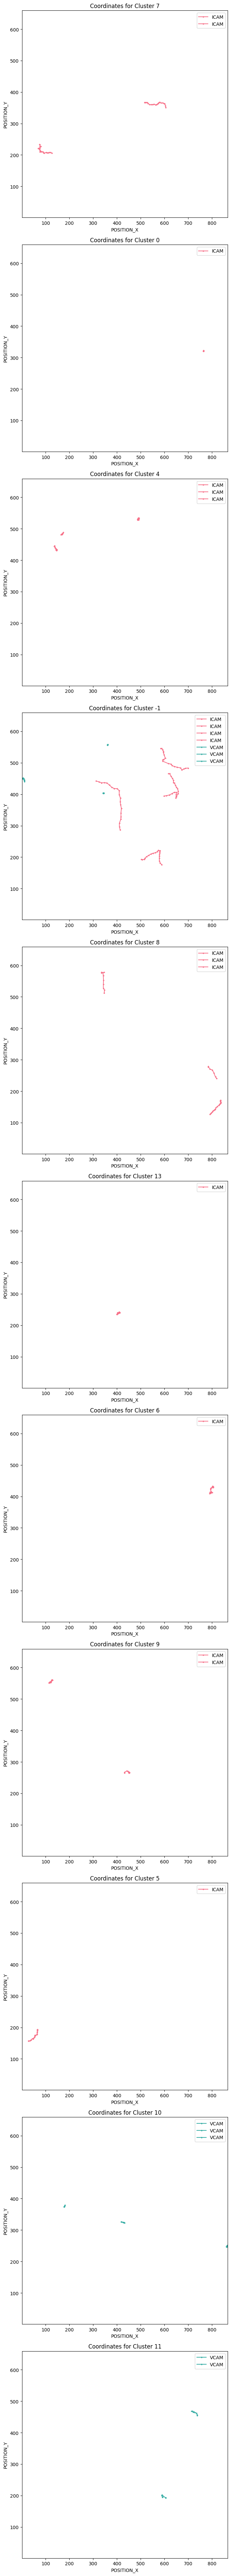

In [ ]:
# @title ##Plot the tracks of the examplar cells


import matplotlib.pyplot as plt
import seaborn as sns

# Extracting actual indices for exemplar rows
exemplar_indices = umap_df.iloc[flattened_exemplars].index

# Add a new column to umap_df to indicate if a point is an exemplar
umap_df['Exemplar'] = 0

# Mark the rows corresponding to exemplars as 1
umap_df.loc[exemplar_indices, 'Exemplar'] = 1

# Determine max and min coordinates from the DataFrame
min_x = merged_spots_df['POSITION_X'].min()
max_x = merged_spots_df['POSITION_X'].max()
min_y = merged_spots_df['POSITION_Y'].min()
max_y = merged_spots_df['POSITION_Y'].max()

# Extract exemplars from the umap_df
exemplar_info = umap_df[umap_df['Exemplar'] == 1]

# Determine the unique clusters from exemplar_info
clusters = exemplar_info['Cluster'].unique()

# Define figure to hold all plots
plt.figure(figsize=(7, len(clusters)*7))

# Iterate over each cluster
for idx, cluster in enumerate(clusters, 1):

    # Extract unique IDs for the current cluster from exemplar_info
    cluster_unique_ids = exemplar_info[exemplar_info['Cluster'] == cluster]['Unique_ID'].tolist()

    # For each unique ID in the cluster, plot the track
    for unique_id in cluster_unique_ids:

        # Filter dataframe based on the unique ID
        unique_df = merged_spots_df[merged_spots_df['Unique_ID'] == unique_id].sort_values(by='POSITION_T')

        # Determine the subplot position: idx represents the current cluster's position
        plt.subplot(len(clusters), 1, idx)

        # Color code tracks based on 'Condition' using seaborn's color palette
        color = sns.color_palette('husl', n_colors=merged_spots_df['Condition'].nunique())[merged_spots_df['Condition'].unique().tolist().index(unique_df['Condition'].iloc[0])]

        plt.plot(unique_df['POSITION_X'], unique_df['POSITION_Y'], marker='o', linestyle='-', markersize=2, color=color, label=unique_df['Condition'].iloc[0])

        # Set title for the subplot (for the first track plotted in this cluster subplot)
        if unique_id == cluster_unique_ids[0]:
            plt.title(f'Coordinates for Cluster {cluster}')

        # Limit the plot dimensions based on your data's extent
        plt.xlim(min_x - 1, max_x + 1)
        plt.ylim(min_y - 1, max_y + 1)

        # Add legend to differentiate tracks based on condition
        plt.legend(loc='best')

        plt.xlabel('POSITION_X')
        plt.ylabel('POSITION_Y')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


## **5.5 Fingerprint**
---

This section is designed to visualize the distribution of different clusters within each condition in a dataset, showing the 'fingerprint' of each cluster per condition.

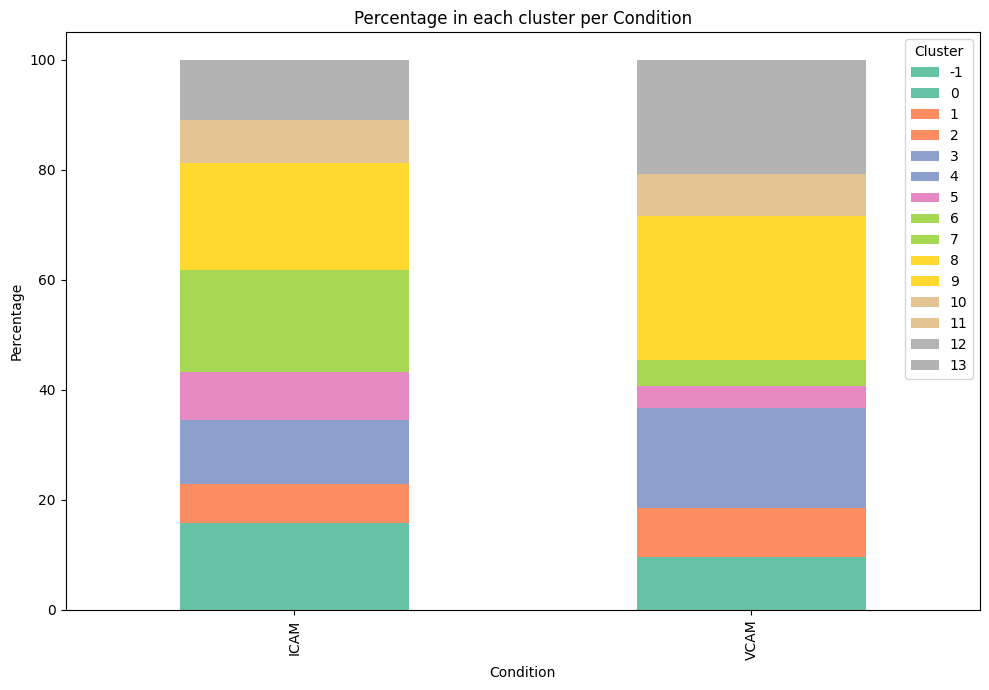

In [ ]:
# @title ##Plot the 'fingerprint' of each cluster per condition

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Group by 'Condition' and 'Cluster' and calculate the size of each group
cluster_counts = umap_df.groupby(['Condition', 'Cluster']).size().reset_index(name='counts')

# Calculate the total number of points per condition
total_counts = umap_df.groupby('Condition').size().reset_index(name='total_counts')

# Merge the DataFrames on 'Condition' to calculate percentages
percentage_df = pd.merge(cluster_counts, total_counts, on='Condition')
percentage_df['percentage'] = (percentage_df['counts'] / percentage_df['total_counts']) * 100

# Save the percentage_df DataFrame as a CSV file
percentage_df.to_csv(Results_Folder+'/UMAP_percentage_results.csv', index=False)

# Pivot the percentage_df to have Conditions as index, Clusters as columns, and percentages as values
pivot_df = percentage_df.pivot(index='Condition', columns='Cluster', values='percentage')

# Fill NaN values with 0 if any, as there might be some Condition-Cluster combinations that are not present
pivot_df.fillna(0, inplace=True)

# Initialize PDF
pdf_pages = PdfPages(Results_Folder+'/UMAP_Cluster_Fingerprint_Plot.pdf')

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
plt.title('Percentage in each cluster per Condition')
plt.ylabel('Percentage')
plt.xlabel('Condition')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the figure to a PDF
pdf_pages.savefig(fig)

# Close the PDF
pdf_pages.close()

# Display the plot
plt.show()



To add:
- Save the cluster number back to the main dataFrame
- Here we want to plots the variable for each cluster for each conditions

## **Part 6. Version log**
---
<font size = 4>While I strive to provide accurate and helpful information, please be aware that:
  - This notebook may contain bugs.
  - Features are currently limited and will be expanded in future releases.

<font size = 4>We encourage users to report any issues or suggestions for improvement. Please check the [repository](https://github.com/guijacquemet/CellTracksColab) regularly for updates and the latest version of this notebook.

#### **Known Issues**:
- Part 5 is limited.
- Tracks are displayed in 2D in section 1.4

<font size = 4>**Version 0.4**

  - Added the possibility to filter and smooth tracks
  - Added spatial and temporal calibration
  - Notebook is streamlined
  - multiple bug fix
  - Remove the t-sne
  - Improved documentation

<font size = 4>**Version 0.3**
  - Fix a nasty bug in the import functions
  - Add basic examplar for UMAP
  - Added the statistical analyses and their explanations.
  - Added a new quality control part that helps assessing the similarity of results between FOV, conditions and repeats
  - Improved part 5 (previously part 4).

<font size = 4>**Version 0.2**
  - Added support for 3D tracks
  - New documentation and metrics added.

<font size = 4>**Version 0.1**
This is the first release of this notebook.

---